In [138]:
library(ape)
library(sde)
remove.packages('rkftools')
devtools::install_local(path='/Users/kf/Dropbox/kfdata/02_Data/my_projects/rkftools', reload=TRUE, quick=FALSE, local=TRUE, dep=FALSE)
options(warn=-1)

Removing package from ‘/Users/kf/anaconda/envs/r-phylogeneticem/lib/R/library’
(as ‘lib’ is unspecified)
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Installing rkftools
'/Users/kf/anaconda/envs/r-phylogeneticem/lib/R/bin/R' --no-site-file  \
  --no-environ --no-save --no-restore --quiet CMD INSTALL  \
  '/private/var/folders/6r/5jx5t6994xs90pl8s4_vddy00000gq/T/RtmpT8lexB/file1355d4ab2238a/rkftools'  \
  --library='/Users/kf/anaconda/envs/r-phylogeneticem/lib/R/library'  \
  --install-tests 

Reloading installed rkftools

Attaching package: ‘rkftools’

The following object is masked _by_ ‘.GlobalEnv’:

    get_node_age



In [139]:
setwd("/Users/kf/Dropbox/kfdata/02_Data/04_Convergence_Duplication/20180614_OU_simulation")

In [172]:
get_optimum_trait_values = function(tree, shift_values, shift_nodes, root_value) {
    stopifnot(length(shift_values)==length(shift_nodes))
    optimum_trait_values = rep(root_value, length(tree$edge.length))
    for (i in 1:length(shift_values)) {
        node_num = shift_nodes[i]
        shift_value = shift_values[i]
        descendent_nodes = get_descendent_num(tree, node_num)
        descendent_edge_bool = tree$edge[,2] %in% c(node_num, descendent_nodes)
        descendent_edge_index = (1:length(descendent_edge_bool))[descendent_edge_bool]
        optimum_trait_values[descendent_edge_index] = optimum_trait_values[descendent_edge_index] + shift_value
    }
    return(optimum_trait_values)
}


pdf 
  2

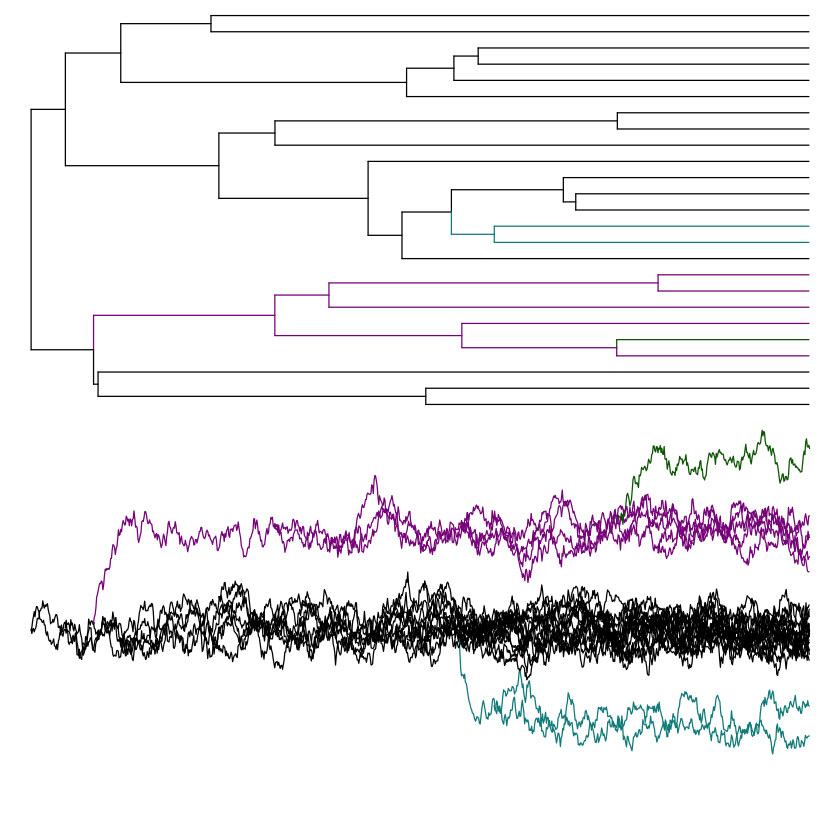

In [258]:
# get_tree
num_leaf = 25
tree = rtree(num_leaf)
tree = chronopl(tree, lambda=0.5, age.min=1, age.max=1, node="root")


# sim_OU
theta = c(0,50,1.5)
root_value = 0
step = 0.001
font_size = 8
optimum_trait_values = get_optimum_trait_values(tree, c(0.75,1,-1), c(5,30,40), 0)
edge_colors = rep('black', length(optimum_trait_values))
opt_unique = unique(optimum_trait_values)
opt_unique = opt_unique[opt_unique!=0]
edge_colors[optimum_trait_values==opt_unique[1]] = 'darkmagenta'
edge_colors[optimum_trait_values==opt_unique[2]] = 'darkgreen'
edge_colors[optimum_trait_values==opt_unique[3]] = 'darkcyan'

node_values = list()
edge_values = list()
node_values[[get_root_num(tree)]] = root_value
for (i in 1:nrow(tree$edge)) {
    if (i %in% names(thetas)) {
        theta_index = i
    } else {
        theta_index = 'default'
    }
    anc_node_age = get_node_age(tree, tree$edge[i,1])
    edge_length = tree$edge.length[i]
    edge_steps = ceiling(edge_length/step)
    edge_values[[i]] = data.frame(matrix(NA, edge_steps+1, 2))
    colnames(edge_values[[i]]) = c('age', 'value')
    edge_values[[i]]$age = rev(seq(anc_node_age-(step*edge_steps), anc_node_age, step))
    x0 = node_values[[tree$edge[i,1]]] - optimum_trait_values[i]
    edge_values[[i]][1,'value'] = x0
    for (s in 2:nrow(edge_values[[i]])) {
        x1 = rcOU(n=1, Dt=step, x0=x0, theta=theta)
        edge_values[[i]][s,'value'] = x1
        x0 = x1
    }
    edge_values[[i]]$value = edge_values[[i]]$value + optimum_trait_values[i]
    node_values[[tree$edge[i,2]]] = edge_values[[i]][nrow(edge_values[[i]]),'value']
}

my_plot = function(tree, edge_values, edge_colors, font_size) {
    par(mfrow=c(2,1), ps=font_size)
    par(mar=c(0,0,0,0)); plot(tree, show.tip.label=FALSE, edge.color=edge_colors)
    par(mar=c(0,0,0,0)); plot(NA, xlim=c(1,0),ylim=c(-2,2),xlab="time",ylab="expression level",las=1, axes=FALSE, ann=FALSE)
    for (i in 1:length(edge_values)) {
        points(edge_values[[i]]$age, edge_values[[i]]$value, type="l", col=edge_colors[i])
    }
}
pdf("OU_simulation.pdf", height=3, width=3)
my_plot(tree, edge_values, edge_colors, font_size)
dev.off()
my_plot(tree, edge_values, edge_colors, font_size)